# Out-of-Distribution Detection

Uses a simulated toy dataset and model to demonstrate how one can use MMLES scores to detect Out of Distribution samples.

In [105]:
import numpy as np
import torch
from models import MlpTriangulationModel, mmles_np
from loss import DisMaxLossSecondPart
from calibration import get_calibrated_temperature
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline

In [106]:
RANDOM_SEED = 42
NUM_CLASSES = 200

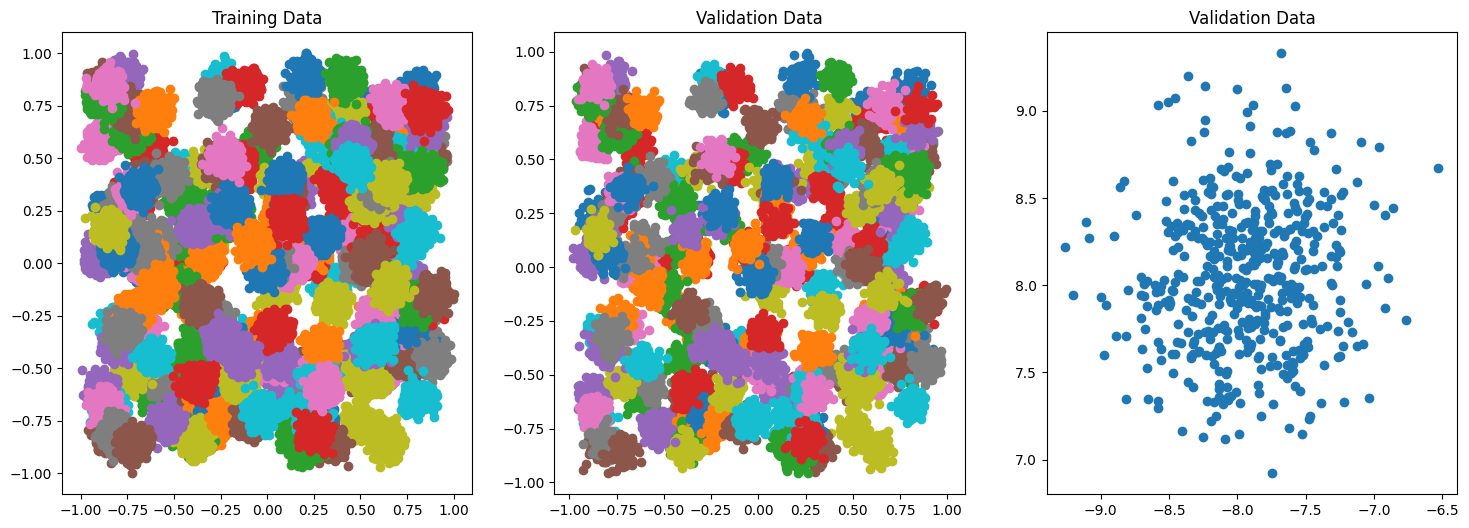

In [107]:
# Generate random data
x_all, y_all = make_blobs(n_samples = 100000, n_features = 2, centers = NUM_CLASSES + 1, cluster_std = 0.4, random_state=RANDOM_SEED,shuffle = True)


x_ood, y_ood = x_all[y_all == NUM_CLASSES], y_all[y_all == NUM_CLASSES]
x_id, y_id = x_all[y_all != NUM_CLASSES], y_all[y_all != NUM_CLASSES]

# Split the data into train and test with 80 train / 20 test
x_train, x_val, y_train, y_val = train_test_split(x_id, y_id, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

# Normalize the samples according to the training data
X_TRAIN_MIN = x_train.min(axis=0)
X_TRAIN_RANGE = x_train.ptp(axis=0)

x_train = 2 * (x_train - X_TRAIN_MIN) / X_TRAIN_RANGE - 1
x_val = 2 * (x_val - X_TRAIN_MIN) / X_TRAIN_RANGE - 1
# x_ood = 2 * (x_ood - X_TRAIN_MIN) / X_TRAIN_RANGE - 1

# Plot the data
fig = plt.figure(figsize =(18,6))
ax = fig.add_subplot(1,3,1)
for label in np.unique(y_train):
    ax.scatter(x_train[y_train == label, 0], x_train[y_train == label,1], label=f"Label = {label}")
ax.set_title("Training Data")
# ax.legend()
ax = fig.add_subplot(1,3,2)
for label in np.unique(y_val):
    ax.scatter(x_val[y_val == label, 0], x_val[y_val == label,1], label=f"Label = {label}")
ax.set_title("Validation Data")
# ax.legend()
ax = fig.add_subplot(1,3,3)
for label in np.unique(y_ood):
    ax.scatter(x_ood[y_ood == label, 0], x_ood[y_ood == label,1], label=f"Label = {label}")
ax.set_title("Validation Data")
# ax.legend()

plt.show()

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [109]:
Xtr, Ytr = torch.tensor(x_train).float().to(device), torch.tensor(y_train).to(device).squeeze()
Xval, Yval = torch.tensor(x_val).float().to(device), torch.tensor(y_val).to(device).squeeze()
Xood, Yood = torch.tensor(x_ood).float().to(device), torch.tensor(y_ood).to(device).squeeze()

0.021506 M parameters
Adjusting LR


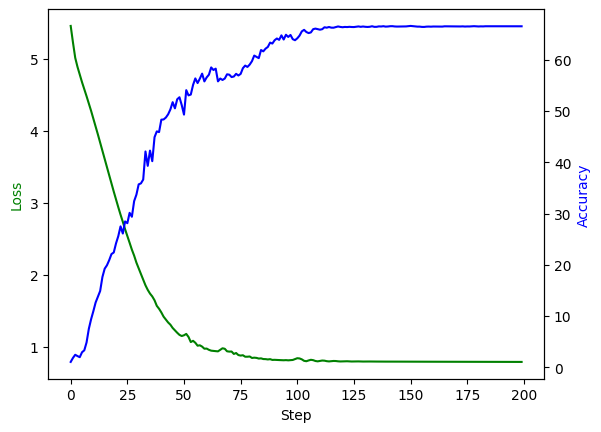

In [110]:
model = MlpTriangulationModel(
    input_size = x_train.shape[-1], # number of channels/features in each input sample
    output_size = NUM_CLASSES, # number of predictable clusters
    hidden_layer_size=64,
    n_hidden_layers=3,
)
model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# This will replace the cross entropy loss
criterion = DisMaxLossSecondPart(model.classifier)

# Create optimizer
init_lr = 3e-2
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

MAX_STEPS = 200
LR_DECAY = [100]
loss_i = []
acc_i = []
for i in range(MAX_STEPS):
    model.train()

    # Predict coordinates and evaluate loss
    outputs = model(Xtr)
    loss = criterion(outputs, Ytr)

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    loss_i.append(loss.item())

    model.eval()
    with torch.no_grad():
        softmax_scores = model.predict_softmax_scores(Xval)
        _, predicted = torch.max(softmax_scores, 1)
        acc = 100 * (predicted == Yval).sum().item() / Yval.size(0)
        # print(acc)
        acc_i.append(acc)
    
    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            g['lr'] *= 0.1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(len(loss_i)), loss_i, 'g-')
ax2.plot(np.arange(len(acc_i)), acc_i, 'b-')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Accuracy', color='b')
plt.show()

In [111]:
# Calibrate the temperature for the model, optimizing ECE metric
model.eval()
with torch.no_grad():
    logits = model(Xval)
    
temperature_for_min_ece = get_calibrated_temperature(logits.cpu().numpy(), Yval.cpu().numpy())
print(temperature_for_min_ece)
model.classifier.temperature.data = torch.tensor([temperature_for_min_ece]).to(device) 

0.0947983197222072


# Detect Out of Distribution (OOD)

- Run prediction on the validation set (in distribution), and the ood set (out of distribution).
- Using confidence dervied from the softmax scores can be useful to delineate "in" vs. "out" of distribution samples, however the MMLES score can produce even better detections. 

0.6651927038842269
0.0


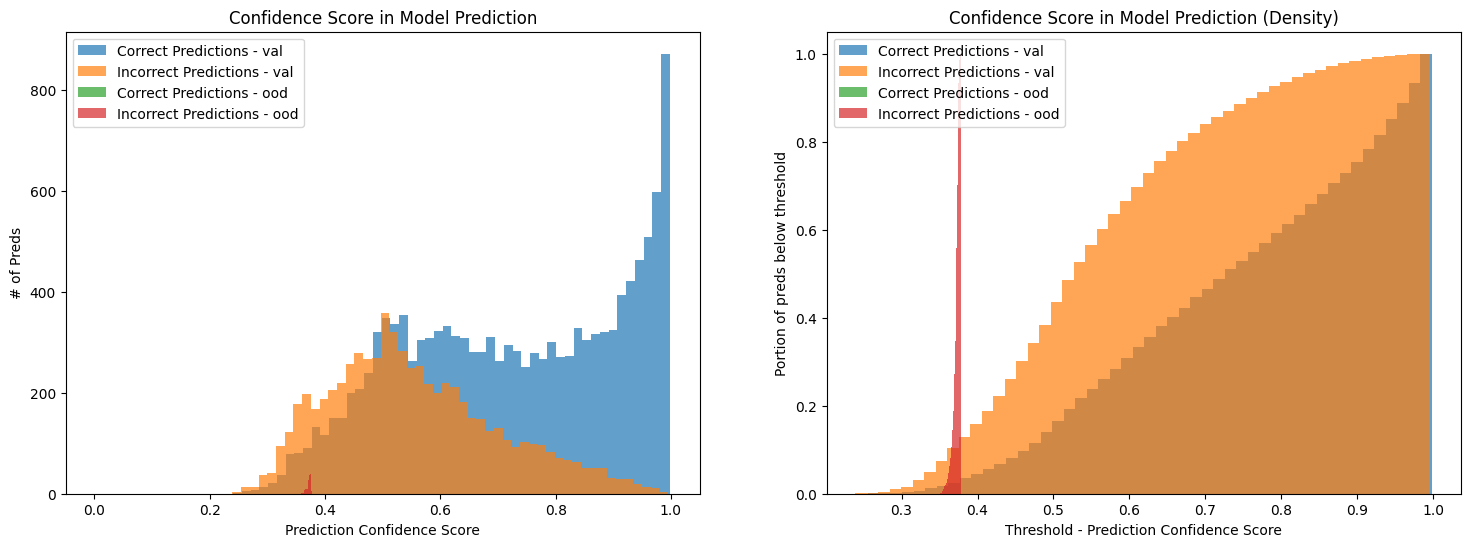

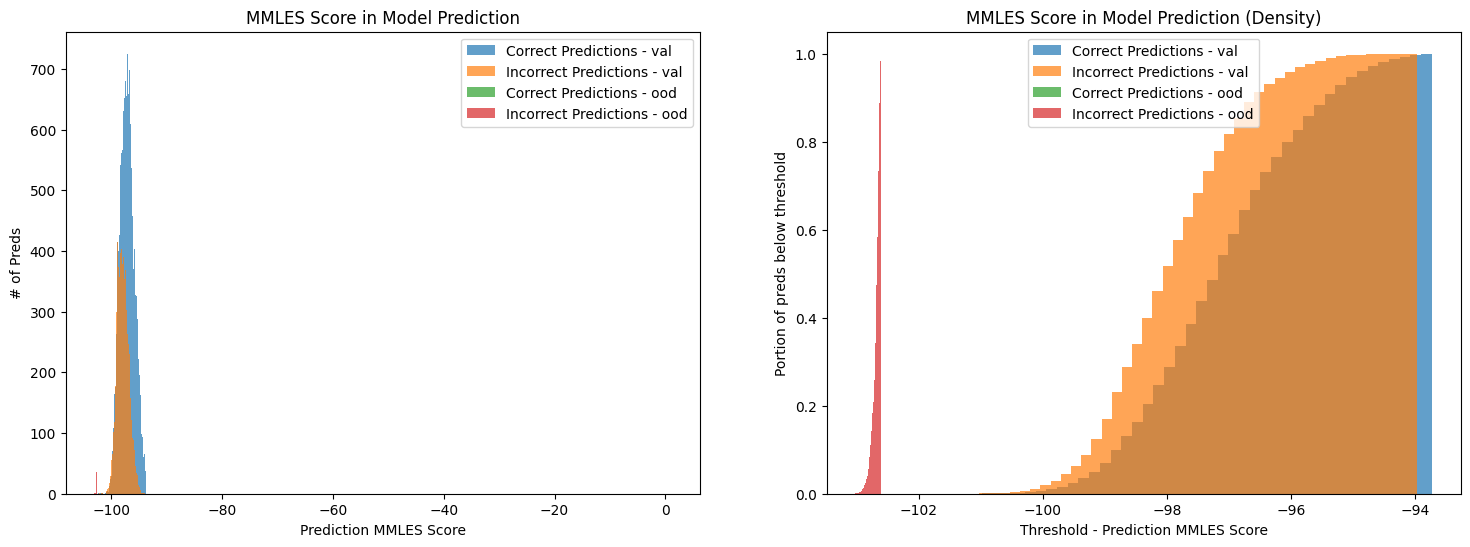

In [112]:
def get_data(split:str):
    if split == "val":
        return Xval, Yval
    if split == "ood":
        return Xood, Yood
    if split == "train":
        return Xtr, Ytr
    raise ValueError(f"Unsupported split: {split}")

by_split = {}
for split in {"val", "ood"}:
    Xsamples, Ysamples = get_data(split)

    model.eval()
    with torch.no_grad():
        logits = model(Xsamples)
        softmax_scores = model.get_softmax_scores_for_logits(logits)

    logits = logits.cpu().numpy()
    softmax_scores = softmax_scores.cpu().numpy()
    mmles_scores = mmles_np(logits)

    predicted_cluster_idxs = softmax_scores.argmax(axis=1).squeeze()
    confidence = softmax_scores.max(axis=1)

    is_correct = predicted_cluster_idxs == Ysamples.squeeze().cpu().numpy()
    print(sum(is_correct)/is_correct.shape[0])

    by_split[split] = {
        "confidence": confidence,
        "mmles_scores": mmles_scores,
        "is_correct": is_correct,
    }

n_bins = 50
for metric_name, metric_key in [("Confidence Score", "confidence"), ("MMLES Score", "mmles_scores")]:
    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(1,2,1)
    for split, v in by_split.items():
        is_correct = v["is_correct"]
        metric = v[metric_key]
        ax.hist(metric[is_correct], bins=n_bins, alpha=0.7, label=f"Correct Predictions - {split}")
        ax.hist(metric[np.invert(is_correct)], bins=n_bins, alpha=0.7, label=f"Incorrect Predictions - {split}")
    ax.set_title(f"{metric_name} in Model Prediction")
    ax.set_xlabel(f"Prediction {metric_name}")
    ax.set_ylabel("# of Preds")
    ax.legend()

    ax = fig.add_subplot(1,2,2)
    for split, v in by_split.items():
        is_correct = v["is_correct"]
        metric = v[metric_key]
        ax.hist(metric[is_correct], bins=n_bins, density=True, cumulative=True, alpha=0.7, label=f"Correct Predictions - {split}")
        ax.hist(metric[np.invert(is_correct)], bins=n_bins, density=True, cumulative=True, alpha=0.7, label=f"Incorrect Predictions - {split}")
    ax.set_title(f"{metric_name} in Model Prediction (Density)")
    ax.set_xlabel(f"Threshold - Prediction {metric_name}")
    ax.set_ylabel("Portion of preds below threshold")
    ax.legend()
    plt.show()

In [115]:
# Determine thresholds
val_scores = by_split["val"]["mmles_scores"]
mmles_score_thresholds = {
    str(p): np.percentile(val_scores, p)
    for p in [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1.0]
}
print(mmles_score_thresholds)

{'0': -102.35904790566515, '0.05': -101.01156283044743, '0.1': -100.71284565474099, '0.25': -100.33496655987776, '0.5': -100.13457710062065, '0.75': -100.00017678930712, '0.9': -99.95630884123959, '0.95': -99.93938238309974, '1.0': -99.92696776594504}


In [117]:

val_scores = by_split["val"]["mmles_scores"]
ood_scores = by_split["ood"]["mmles_scores"]
for p, t in mmles_score_thresholds.items():
    ood_flagged_as_ood = ood_scores < t
    ood_flagged_as_ood_perc = 100 * ood_flagged_as_ood.sum() / ood_flagged_as_ood.shape[0]
    id_flagged_as_ood = val_scores < t
    id_flagged_as_ood_perc = 100 * id_flagged_as_ood.sum() / id_flagged_as_ood.shape[0]
    print(50*"=")
    print(f"Using p={p}, thresh={t:.2f}")
    print(f"\t{id_flagged_as_ood_perc:.2f}% of valid (in distribution) samples would be incorrectly flagged as OOD")
    print(f"\t{ood_flagged_as_ood_perc:.2f}% of invalid (out of distribution) samples would be correctly flagged as OOD")


Using p=0, thresh=-102.36
	0.00% of valid (in distribution) samples would be incorrectly flagged as OOD
	100.00% of invalid (out of distribution) samples would be correctly flagged as OOD
Using p=0.05, thresh=-101.01
	0.05% of valid (in distribution) samples would be incorrectly flagged as OOD
	100.00% of invalid (out of distribution) samples would be correctly flagged as OOD
Using p=0.1, thresh=-100.71
	0.10% of valid (in distribution) samples would be incorrectly flagged as OOD
	100.00% of invalid (out of distribution) samples would be correctly flagged as OOD
Using p=0.25, thresh=-100.33
	0.25% of valid (in distribution) samples would be incorrectly flagged as OOD
	100.00% of invalid (out of distribution) samples would be correctly flagged as OOD
Using p=0.5, thresh=-100.13
	0.50% of valid (in distribution) samples would be incorrectly flagged as OOD
	100.00% of invalid (out of distribution) samples would be correctly flagged as OOD
Using p=0.75, thresh=-100.00
	0.75% of valid (in d